In this notebook the "MSFT" stock data is loaded and attempts are made to build a Machine Learning model to predict if following day stock Closing price will be higher than the day before (Closing price indicator) using Random Forest classifier. Classifier principal metrics are calculated (Recall, Precission, Accuracy, F1 score and confusion matrix). Procedure is repeated and same metrics are provided after slight feature engineering. The results obtained here act as a baseline for the subsequent work.   

<a id="top"></a>
1. [Data collection and processing](#01)  
    1. [Feature engineering](#011)
1. [Random Forest Classifier predictions](#02)
1. [Follow up](#03)

<a id="01"></a> 
# Data collection and processing
[back to top](#top)

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

ticker = 'MSFT'
ticker_data = yf.Ticker(ticker)

data = ticker_data.history(period="max")
data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.055121,0.063227,0.055121,0.060524,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060524,0.063767,0.060524,0.062686,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062686,0.064307,0.062686,0.063767,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063767,0.064307,0.061605,0.062145,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.062145,0.062686,0.060524,0.061065,47894400,0.0,0.0


In [3]:
hist= data.copy(deep=True)

<Axes: xlabel='Date'>

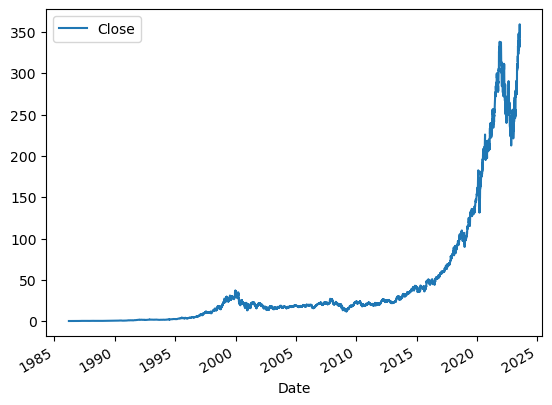

In [4]:
hist.plot.line(y="Close", use_index=True)

In [5]:
del hist["Dividends"]
del hist["Stock Splits"]

In [6]:
hist["Tomorrow"] = hist["Close"].shift(-1)
hist["Target"] = (hist["Tomorrow"] > hist["Close"]).astype(int)

In [7]:
hist = hist.loc["2000-01-01":].copy()

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

target = 'Target'
predictors = ["Close", "Volume", "Open", "High", "Low"]

train = hist.iloc[:-100]
test = hist.iloc[-100:]

model.fit(train[predictors], train[target])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [14]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.631578947368421

In [15]:
def predict(train, test, predictors, target, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)
    return combined

In [16]:
def backtest(data, model, predictors, taget, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors,target, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [17]:
predictions = backtest(hist, model, predictors, target)

In [18]:
predictions["Predictions"].value_counts()

0    2120
1    1305
Name: Predictions, dtype: int64

prediction says that 1200 times the price would increase

In [19]:
precision_score(predictions["Target"], predictions["Predictions"])

0.518007662835249

In [20]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.520876
0    0.479124
Name: Target, dtype: float64

In [21]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
recall = recall_score(predictions["Target"], predictions["Predictions"])
precision = precision_score(predictions["Target"], predictions["Predictions"])
accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
f1 = f1_score(predictions["Target"], predictions["Predictions"])
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Recall: 0.3789237668161435 
Precision: 0.518007662835249 
Accuracy: 0.49284671532846713 
F1: 0.43768209776626743


Recall: how many actually possitive cases were correctly identified TP/(TP+FN)  
Precision: how many positive predictions were REALLY possitive TP/(TP+FP)  
Accuracy: number of correct prediction/ number of all predictions (TP+TN)/all  

High recall: more likely to mark negative results as possitive  
                when price was going down we indicated that it will go up  
High precision: more likely to mark possitive result as negative  

In [24]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(predictions["Target"], predictions["Predictions"])

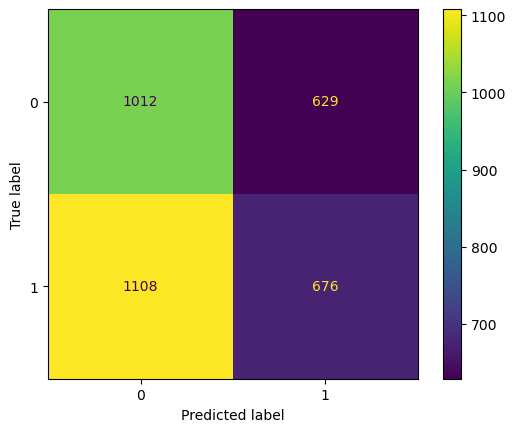

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()
plt.show()

Model correctly identified price not increasing the following day 1012 times (TP) and correctly identified price INcreasing the following day 672 times (TN). The FN case - The Price increased while model predicted a decrease 1109 times (almost the same as TP and FP - 625. 

<a id="011"></a>
## Lets crate new predictors
[back to top](#top)

In [26]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = hist.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    hist[ratio_column] = hist["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    hist[trend_column] = hist.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [27]:
hist = hist.dropna()

In [28]:
hist.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2003-12-26 00:00:00-05:00,16.988564,17.114173,16.957162,17.089050,12076900,17.246054,1,1.003134,1.0,1.000809,1.0,1.010061,31.0,1.048220,129.0,0.894303,489.0
2003-12-29 00:00:00-05:00,17.089043,17.290018,17.057641,17.246054,40426700,17.283743,1,1.004573,2.0,1.009262,2.0,1.019896,32.0,1.057551,130.0,0.903361,490.0
2003-12-30 00:00:00-05:00,17.214658,17.302583,17.208377,17.283743,34406600,17.189537,0,1.001091,2.0,1.008946,3.0,1.023010,32.0,1.059716,130.0,0.906196,490.0
2003-12-31 00:00:00-05:00,17.220939,17.302584,17.101610,17.189537,42198900,17.239777,1,0.997267,1.0,1.001830,3.0,1.018480,31.0,1.053825,129.0,0.902063,490.0
2004-01-02 00:00:00-05:00,17.321422,17.440750,17.164411,17.239777,44487700,17.673124,1,1.001459,1.0,1.001752,4.0,1.022425,32.0,1.056855,129.0,0.905529,490.0


<a id='02'></a>
# Predictions
[back to top](#top)

In [29]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [30]:
def predict(train, test, predictors, target, model, thrsh = 0.6):
    #0.6 probability threshold so that we have a better confidence that price will increase
    model.fit(train[predictors], train[target])
    preds = model.predict_proba(test[predictors])[:,1] #predicts probability
    preds[preds >=thrsh] = 1
    preds[preds <thrsh] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)
    return combined

In [31]:
target = 'Target'
#predictors = predictors + new_predictors
predictors = new_predictors + ["Close", "Volume"] #the other prices tell us little about the prediction 
print('Predictors:')
print(predictors)
predictions = backtest(hist, model, predictors, target)

Predictors:
['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000', 'Close', 'Volume']


In [32]:
predictions["Predictions"].value_counts()

0.0    2234
1.0     190
Name: Predictions, dtype: int64

So now we only predict 200 days when price will increase in contrary to rpevious results where it was 1200

In [33]:
precision_score(predictions["Target"], predictions["Predictions"])

0.48947368421052634

In [34]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.528878
0    0.471122
Name: Target, dtype: float64

In [35]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(predictions["Target"], predictions["Predictions"])
cf_matrix

array([[1045,   97],
       [1189,   93]], dtype=int64)

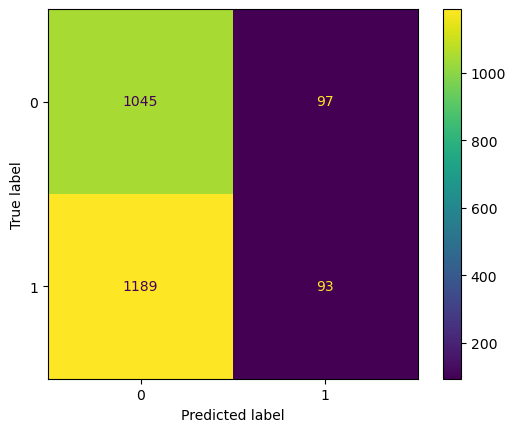

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()
plt.show()

In [37]:
recall = recall_score(predictions["Target"], predictions["Predictions"])
precision = precision_score(predictions["Target"], predictions["Predictions"])
accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
f1 = f1_score(predictions["Target"], predictions["Predictions"])
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Recall: 0.07254290171606864 
Precision: 0.48947368421052634 
Accuracy: 0.46947194719471946 
F1: 0.1263586956521739


<a id="03"></a>
# Follow up
[back to top](#top)

The follow up to this baseline prediction is continued in the succeeding Jupyter notebook